运行环境：win10  
使用包的版本：  
numpy VERSION 1.20.1  
pandas VERSION 1.2.4  
seaborn VERSION 0.11.1  
matplotlib VERSION 3.3.4  
sklearn VERSION 0.24.1  
statsmodels VERSION 0.12.2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols 
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline
data = pd.read_csv("BikeData.csv")
data.head()

,Date,Rented Bike Count,Hour,Temperature(℃),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(℃),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


定义类

In [2]:
class Date:
    def __init__(self, date, season, holiday, fucntioningday):
        self.date = datetime.datetime(*[int(m) for m in date.split()]).strftime("%m/%d/%Y")
        self.season = season
        self.holiday = holiday
        self.fucntioningday = fucntioningday
    def DateInfo(self):
        print('日期:'+self.date,'季节:'+self.season,'是否假期:'+self.holiday,'是否工作日:'+self.fucntioningday)

In [3]:
class Weather:
    def __init__(self, temp, hum, windspeed, visibility, dtemp, sr, rain, snow):
        self.temp = temp
        self.hum = hum
        self.windspeed = windspeed
        self.visibility = visibility
        self.dtemp = dtemp
        self.sr = sr
        self.rain = rain
        self.snow = snow
    def WeatherInfo(self):
        print('日期:'+self.date,'温度:'+self.temp,'湿度:'+self.hum,'风速:'+self.windspeed, '可见度:'+self.visibility,
             '露点温度:'+self.dtemp, '太阳辐射'+self.sr, '降雨量'+self.rain, '降雪量'+self.snow)

In [4]:
class BikeRent:
    members = 0
    def __init__(self, date, count, hour, temp, hum, windspeed, visibility, dtemp, sr, rain, snow,season, holiday, fucntioningday):
        Date.__init__(self, date, season, holiday, fucntioningday)
        Weather.__init__(self, temp, hum, windspeed, visibility, dtemp, sr, rain, snow) 
        self.count = count
        self.hour = hour
        BikeRent.members += 1
    def add(self):
        dn = pd.DataFrame({'Date':self.date, 'Rented Bike Count':self.count, 'Hour':self.hour, 'Temperature(℃)':self.temp, 
                           'Humidity(%)':self.hum, 'Wind speed (m/s)':self.windspeed, 'Visibility (10m)':self.visibility, 
                           'Dew point temperature(℃)':self.dtemp, 'Solar Radiation (MJ/m2)':self.sr, 'Rainfall(mm)':self.rain,
                           'Snowfall (cm)':self.snow, 'Seasons':self.season, 'Holiday':self.holiday, 'Functioning Day':self.fucntioningday},
                          index=[BikeRent.members])
        return dn

In [5]:
b1 = BikeRent('2020 01 02', 70, 3, 5.0, 40, 0.9, 2000, -17.2, 0, 0, 0, 'Winter', 'No Holiday', 'Yes')

In [6]:
b1.add()

,Date,Rented Bike Count,Hour,Temperature(℃),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(℃),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
1,01/02/2020,70,3,5.0,40,0.9,2000,-17.2,0,0,0,Winter,No Holiday,Yes


In [7]:
data.loc[data['Seasons'] == 'Winter','Seasons'] = 4
data.loc[data['Seasons'] == 'Spring','Seasons'] = 1
data.loc[data['Seasons'] == 'Summer','Seasons'] = 2
data.loc[data['Seasons'] == 'Autumn','Seasons'] = 3
data.loc[data['Holiday'] == 'No Holiday','Holiday'] = 0
data.loc[data['Holiday'] == 'Holiday','Holiday'] = 1
data.loc[data['Functioning Day'] == 'Yes','Functioning Day'] = 1
data.loc[data['Functioning Day'] == 'No','Functioning Day'] = 0
data1 = data.drop('Date', axis=1)
data1['Hour']= data['Hour'].astype('category')
data1['Seasons'] = data['Seasons'].astype('category')
data1['Holiday'] = data['Holiday'].astype('category')
data1['Functioning Day'] = data['Functioning Day'].astype('category')
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Rented Bike Count         8760 non-null   int64   
 1   Hour                      8760 non-null   category
 2   Temperature(℃)            8760 non-null   float64 
 3   Humidity(%)               8760 non-null   int64   
 4   Wind speed (m/s)          8760 non-null   float64 
 5   Visibility (10m)          8760 non-null   int64   
 6   Dew point temperature(℃)  8760 non-null   float64 
 7   Solar Radiation (MJ/m2)   8760 non-null   float64 
 8   Rainfall(mm)              8760 non-null   float64 
 9   Snowfall (cm)             8760 non-null   float64 
 10  Seasons                   8760 non-null   category
 11  Holiday                   8760 non-null   category
 12  Functioning Day           8760 non-null   category
dtypes: category(4), float64(6), int64(3)
memory usag

In [8]:
#定义一个函数，判断是否有重复的数据，如果有，则抛出异常
class RepeatException(Exception): pass
def CheckRepetition(df):
    if len(set(df.duplicated())) == 2:
        raise RepeatException('有重复数据')
    else:
        print('无重复数据')
#检测一些数据取值是否合理
def check_num(num):
    for i in range(0,len(num)):
        if num[i] >=0:
            pass
        else:
            raise ValueError('数据错误，', num.name, '必须要大于等于0')
    print(num.name,'无错误数据')
def check_hum(hum):
    for i in range(0,len(hum)):
        if hum[i] >= 0:
            pass
        else:
            raise ValueError('数据错误，Humidity必须在0到100之间')
    print('Humidity无错误数据')
def check_temp(temp):
    for i in range(0,len(temp)):
        if(temp[i]<=-40)| (temp[i]>=40):
            raise ValueError('数据错误，温度异常')
        else:
            pass
    print('温度无错误数据')

In [9]:
CheckRepetition(data1)

无重复数据


In [10]:
check_num(data1['Rented Bike Count'])
check_num(data1['Wind speed (m/s)'])
check_num(data1['Visibility (10m)'])
check_num(data1['Solar Radiation (MJ/m2)'])
check_num(data1['Rainfall(mm)'])
check_num(data1['Snowfall (cm)'])
check_temp(data1['Temperature(℃)'])
check_temp(data1['Dew point temperature(℃)'])
check_hum(data1['Humidity(%)'])

Rented Bike Count 无错误数据
Wind speed (m/s) 无错误数据
Visibility (10m) 无错误数据
Solar Radiation (MJ/m2) 无错误数据
Rainfall(mm) 无错误数据
Snowfall (cm) 无错误数据
温度无错误数据
温度无错误数据
Humidity无错误数据


In [11]:
data1.describe()

,Rented Bike Count,Temperature(℃),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(℃),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


Text(0, 0.5, 'Snowfall (cm)')

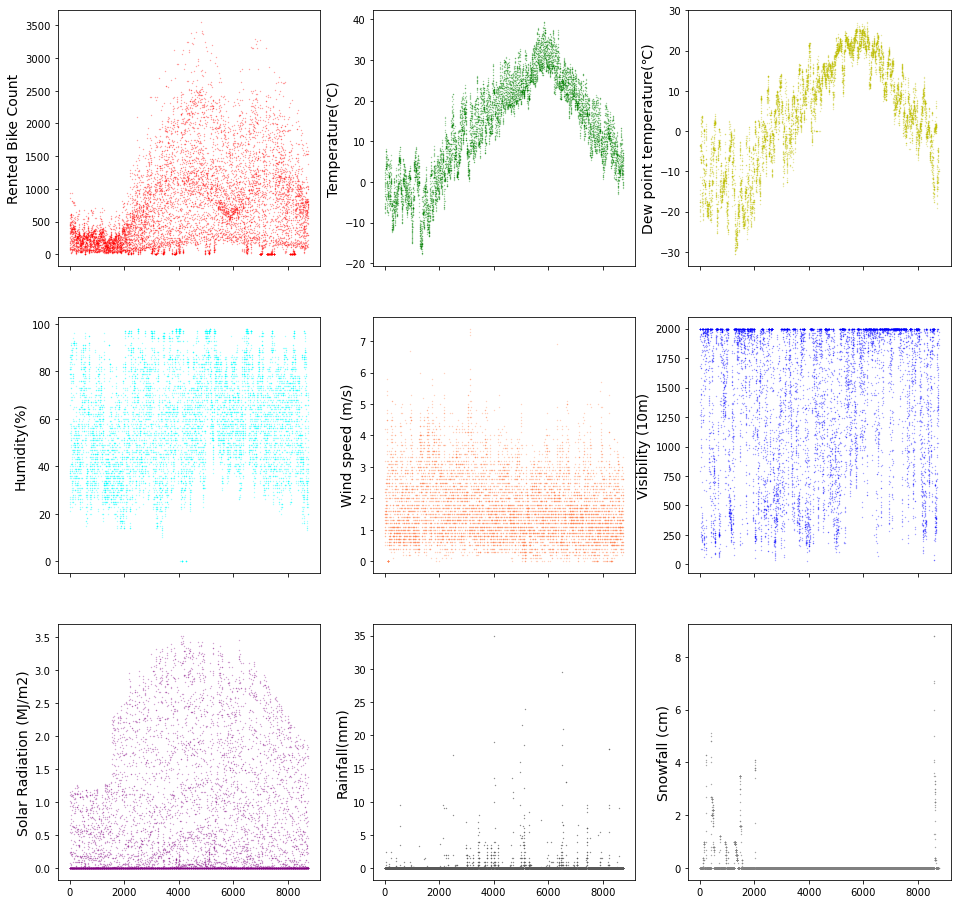

In [12]:
#做散点图
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(3, 3, figsize=(16, 16),sharex=True)
ax[0][0].scatter(range(data1.shape[0]),data1['Rented Bike Count'].values, s=0.1,alpha=0.5, color='r')
ax[0][0].set_ylabel('Rented Bike Count', fontsize=14)
ax[0][1].scatter(range(data1.shape[0]),data1['Temperature(℃)'].values,s=0.1,alpha=0.5, color='g')
ax[0][1].set_ylabel('Temperature(℃)', fontsize=14)
ax[0][2].scatter(range(data1.shape[0]),data1['Dew point temperature(℃)'].values,s=0.1,alpha=0.5, color='y')
ax[0][2].set_ylabel('Dew point temperature(℃)', fontsize=14)
ax[1][0].scatter(range(data1.shape[0]),data1['Humidity(%)'].values,s=0.1,alpha=0.5, color='cyan')
ax[1][0].set_ylabel('Humidity(%)', fontsize=14)
ax[1][1].scatter(range(data1.shape[0]),data1['Wind speed (m/s)'].values,s=0.1,alpha=0.5, color=(1.0,0.5,0.3))
ax[1][1].set_ylabel('Wind speed (m/s)', fontsize=14)
ax[1][2].scatter(range(data1.shape[0]),data1['Visibility (10m)'].values,s=0.1,alpha=0.5, color='b')
ax[1][2].set_ylabel('Visibility (10m)', fontsize=14)
ax[2][0].scatter(range(data1.shape[0]),data1['Solar Radiation (MJ/m2)'].values,s=0.1,alpha=0.5, color='purple')
ax[2][0].set_ylabel('Solar Radiation (MJ/m2)', fontsize=14)
ax[2][1].scatter(range(data1.shape[0]),data1['Rainfall(mm)'].values,s=0.1,alpha=1, color='#595959')
ax[2][1].set_ylabel('Rainfall(mm)', fontsize=14)
ax[2][2].scatter(range(data1.shape[0]),data1['Snowfall (cm)'].values,s=0.1,alpha=1, color='gray')
ax[2][2].set_ylabel('Snowfall (cm)', fontsize=14)

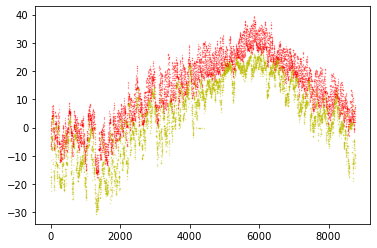

In [13]:
#温度和露点温度的散点图
plt.scatter(range(data1.shape[0]),data1['Temperature(℃)'].values, s=0.1,alpha=0.5, color='r')
plt.scatter(range(data1.shape[0]),data1['Dew point temperature(℃)'].values, s=0.1,alpha=0.5, color='y')

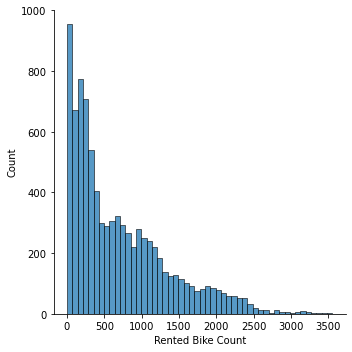

In [14]:
#直方图
sns.displot(data1['Rented Bike Count'],bins=50)

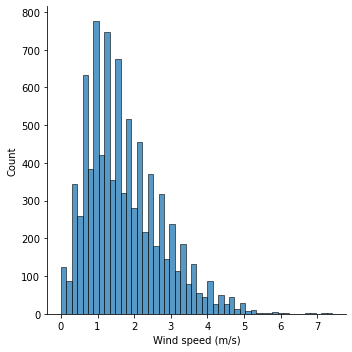

In [15]:
#直方图
sns.displot(data1['Wind speed (m/s)'],bins=50)

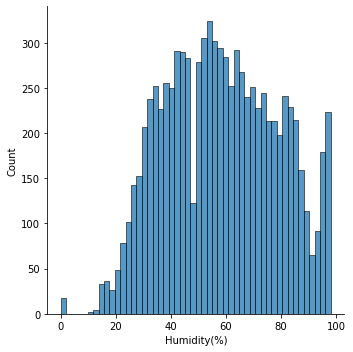

In [16]:
sns.displot(data1['Humidity(%)'],bins=50)

<AxesSubplot:>

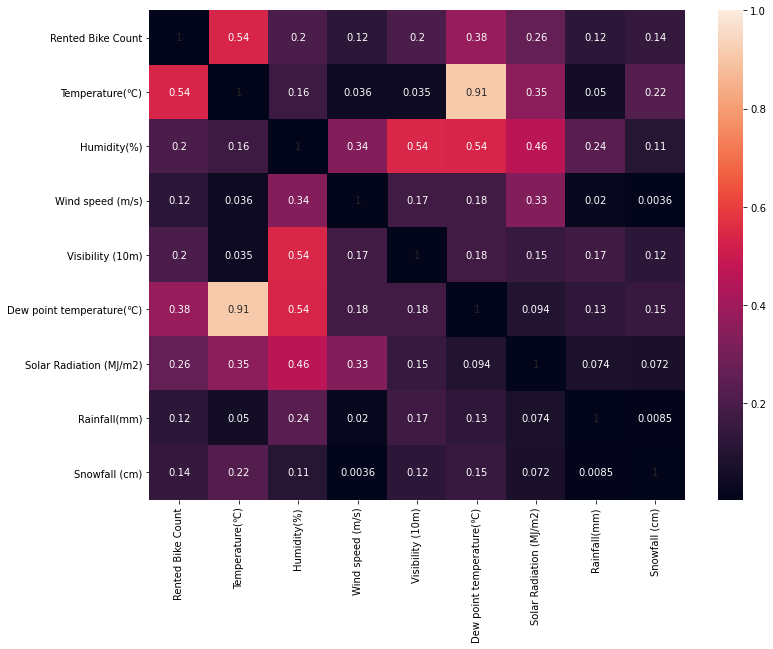

In [17]:
#相关图
data1_corr = data1.corr().abs()
plt.subplots(figsize=(12,9))
sns.heatmap(data1_corr,annot=True)
sns.heatmap(data1_corr,mask=data1_corr<1,cbar=False)

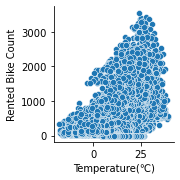

In [18]:
sns.pairplot(data1,x_vars='Temperature(℃)',y_vars='Rented Bike Count')

In [19]:
#打乱数据
data2 = data1
data2 = shuffle(data2)

In [21]:
#引入虚拟变量
dummies1 = pd.get_dummies(data2['Hour'], prefix='Hour')
del dummies1['Hour_23']
dummies2 = pd.get_dummies(data2['Seasons'], prefix='Seasons')
del dummies2['Seasons_4']
dummies3 = pd.get_dummies(data2['Holiday'], prefix='Holiday')
del dummies3['Holiday_1']
dummies4 = pd.get_dummies(data2['Functioning Day'], prefix='Functioning Day')
del dummies4['Functioning Day_1']
data2_type = pd.concat([dummies1,dummies2,dummies3,dummies4],axis=1)
data2_num = data2[['Temperature(℃)','Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 
                             'Rainfall(mm)', 'Snowfall (cm)', 'Rented Bike Count']]
data2 = pd.concat((data2_type,data2_num),axis=1)

In [22]:
#分离训练集和测试集
train = data2.iloc[:int(0.7*data2.shape[0]),:]
test = data2.iloc[int(0.7*data2.shape[0]):,:]
x_train = train.drop('Rented Bike Count',axis=1)
x_test = test.drop('Rented Bike Count',axis=1)
y_train = train['Rented Bike Count']
y_test = test['Rented Bike Count']

In [23]:
x_train_num = x_train[['Temperature(℃)','Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 
                             'Rainfall(mm)', 'Snowfall (cm)']]
x_train_type = x_train.drop(['Temperature(℃)','Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 
                             'Rainfall(mm)', 'Snowfall (cm)'],axis=1)
x_test_num = x_test[['Temperature(℃)','Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 
                             'Rainfall(mm)', 'Snowfall (cm)']]
x_test_type = x_test.drop(['Temperature(℃)','Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 
                             'Rainfall(mm)', 'Snowfall (cm)'],axis=1)

In [24]:
# 每轮循环中计算各个变量的VIF，并删除VIF>threshold 的变量
def vif(X, thres=10.0):
    col = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:,col].values, ix)
               for ix in range(X.iloc[:,col].shape[1])]
        maxvif = max(vif)
        maxix = vif.index(maxvif)
        if maxvif > thres:
            print('delete=',X.columns[col[maxix]],'  ', 'vif=',maxvif )
            del col[maxix]
            dropped = True
    print('Remain Variables:', list(X.columns[col]))
    print('VIF:', vif)
    return list(X.columns[col]) 

In [25]:
vif(x_train_num)

Remain Variables: ['Temperature(℃)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
VIF: [3.1510746203051156, 4.804477125870264, 4.057770822141075, 4.422049298162782, 2.211318622623258, 1.0852421093317246, 1.116925566634445]


['Temperature(℃)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)']

In [26]:
#标准化处理
ss_x_train = StandardScaler()
ss_x_test = StandardScaler()
x_train_num = ss_x_train.fit_transform(x_train_num)
x_test_num = ss_x_test.fit_transform(x_test_num)
ss_y_train = StandardScaler()
ss_y_test = StandardScaler()
y_train = ss_y_train.fit_transform(y_train.values.reshape(-1,1))
y_test = ss_y_test.fit_transform(y_test.values.reshape(-1,1))

In [27]:
#还原特征矩阵
x_train_num = pd.DataFrame(x_train_num,columns=['Temperature(℃)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 
                                      'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'])
x_test_num = pd.DataFrame(x_test_num,columns=['Temperature(℃)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 
                                      'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'])
x_train_type = x_train_type.reset_index(drop=True)
x_test_type = x_test_type.reset_index(drop=True)
x_train = pd.concat((x_train_type,x_train_num),axis=1)
x_test = pd.concat((x_test_type,x_test_num),axis=1)

In [28]:
#用最小二乘做线性拟合
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

In [29]:
print("训练集r2_score评分：",r2_score(y_train,y_train_pred))
print("测试集r2_score评分：",r2_score(y_test,y_test_pred))

训练集r2_score评分： 0.6623792430542317
测试集r2_score评分： 0.6588984110090755


In [30]:
from statsmodels.formula.api import ols 
import statsmodels.api as sm
x_train2 = sm.add_constant(x_train)
est = sm.OLS(y_train, x_train2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     341.7
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:54:42   Log-Likelihood:                -5371.8
No. Observations:                6132   AIC:                         1.082e+04
Df Residuals:                    6096   BIC:                         1.106e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [31]:
#将风速，可见度，降雪量三个变量剔除，再做标准化
x_train = train.drop(['Rented Bike Count','Wind speed (m/s)', 'Visibility (10m)','Snowfall (cm)'],axis=1)
x_test = test.drop(['Rented Bike Count','Wind speed (m/s)', 'Visibility (10m)','Snowfall (cm)'],axis=1)
y_train = train['Rented Bike Count']
y_test = test['Rented Bike Count']

x_train_num = x_train[['Temperature(℃)','Humidity(%)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)']]
x_train_type = x_train.drop(['Temperature(℃)','Humidity(%)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)'],axis=1)
x_test_num = x_test[['Temperature(℃)','Humidity(%)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)']]
x_test_type = x_test.drop(['Temperature(℃)','Humidity(%)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)'],axis=1)

ss_x_train = StandardScaler()
ss_x_test = StandardScaler()
x_train_num = ss_x_train.fit_transform(x_train_num)
x_test_num = ss_x_test.fit_transform(x_test_num)

ss_y_train = StandardScaler()
ss_y_test = StandardScaler()
y_train = ss_y_train.fit_transform(y_train.values.reshape(-1,1))
y_test = ss_y_test.fit_transform(y_test.values.reshape(-1,1))

x_train_num = pd.DataFrame(x_train_num,columns=['Temperature(℃)', 'Humidity(%)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)'])
x_test_num = pd.DataFrame(x_test_num,columns=['Temperature(℃)', 'Humidity(%)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)'])

x_train_type = x_train_type.reset_index(drop=True)
x_test_type = x_test_type.reset_index(drop=True)

x_train = pd.concat((x_train_type,x_train_num),axis=1)
x_test = pd.concat((x_test_type,x_test_num),axis=1)

In [32]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)
print("训练集r2_score评分：",r2_score(y_train,y_train_pred))
print("测试集r2_score评分：",r2_score(y_test,y_test_pred))

训练集r2_score评分： 0.6621316659974013
测试集r2_score评分： 0.6584320932068102


In [33]:
x_train2 = sm.add_constant(x_train)
est = sm.OLS(y_train, x_train2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     373.5
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:56:50   Log-Likelihood:                -5374.0
No. Observations:                6132   AIC:                         1.081e+04
Df Residuals:                    6099   BIC:                         1.104e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

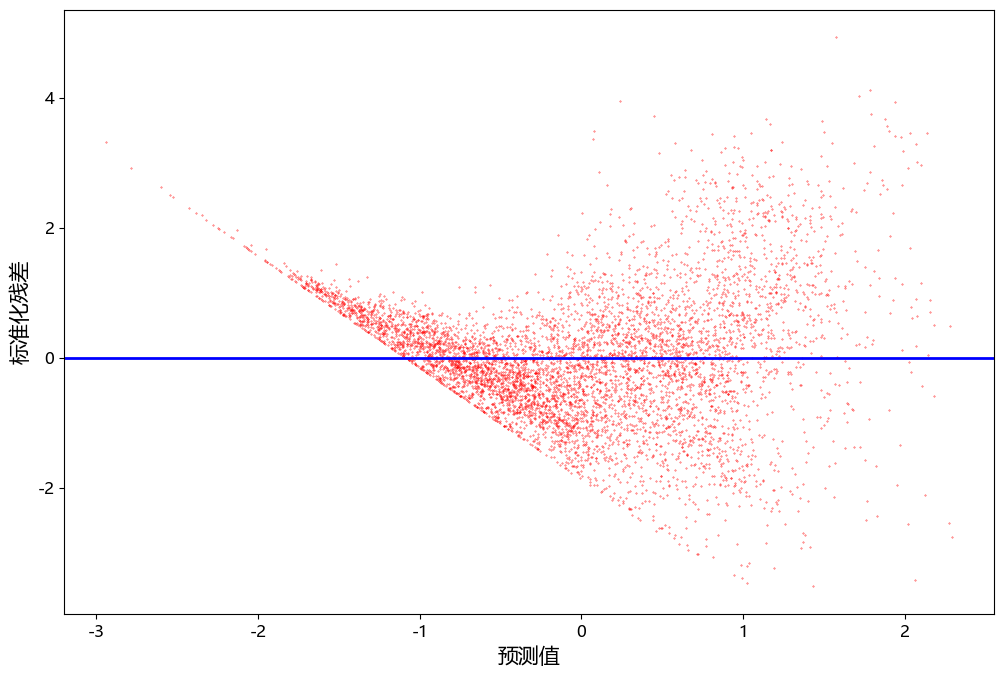

In [34]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus']=False 
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(est2.predict(x_train2),(est2.resid-est2.resid.mean())/est2.resid.std(),s=0.1, c='r',alpha=0.9)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('预测值',fontsize=15)
plt.ylabel('标准化残差',fontsize=15)
plt.axhline(y = 0, color = 'b', linewidth = 2)
plt.show()

In [35]:
#white检验
sm.stats.diagnostic.het_white(est2.resid, exog = est2.model.exog)

(2621.476565001451, 0.0, 16.52990234156356, 0.0)

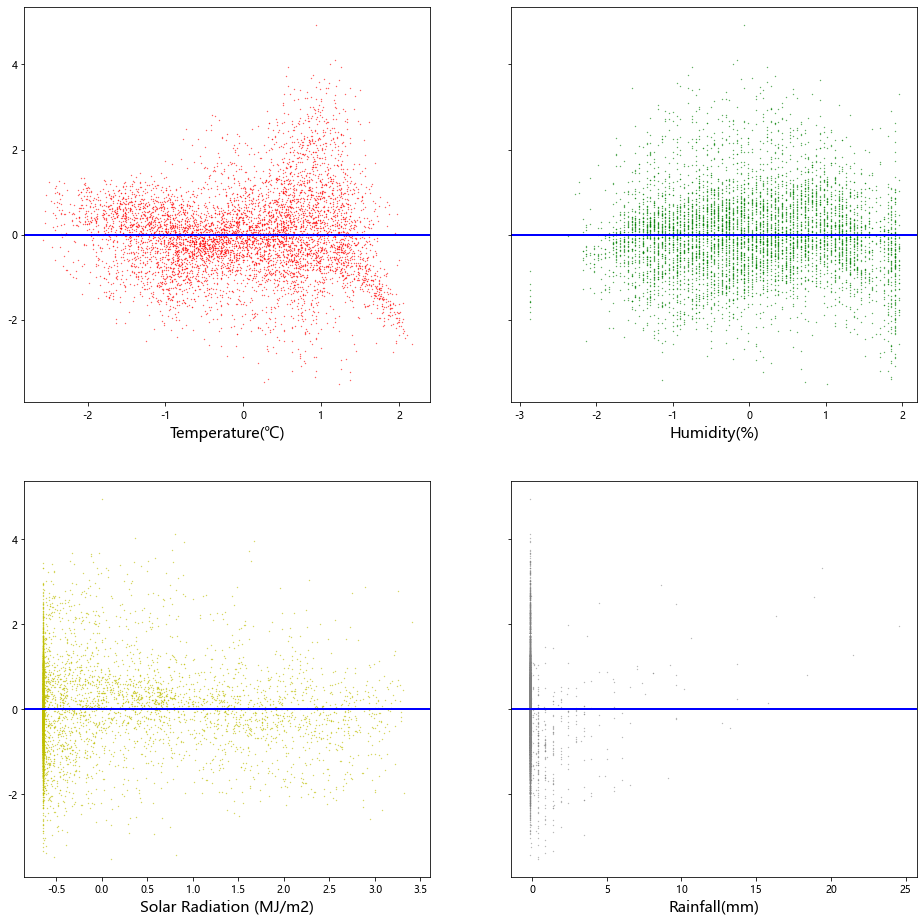

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16),sharey=True)
ax[0][0].scatter(x_train['Temperature(℃)'], (est2.resid-est2.resid.mean())/est2.resid.std(),s=0.1, c='r',alpha=0.9)
ax[0][0].set_xlabel('Temperature(℃)',fontsize=15)
ax[0][0].axhline(y = 0, color = 'b', linewidth = 2)
ax[0][1].scatter(x_train['Humidity(%)'], (est2.resid-est2.resid.mean())/est2.resid.std(),s=0.1, c='g',alpha=0.9)
ax[0][1].set_xlabel('Humidity(%)',fontsize=15)
ax[0][1].axhline(y = 0, color = 'b', linewidth = 2)
ax[1][0].scatter(x_train['Solar Radiation (MJ/m2)'], (est2.resid-est2.resid.mean())/est2.resid.std(),s=0.1, c='y',alpha=0.9)
ax[1][0].axhline(y = 0, color = 'b', linewidth = 2)
ax[1][0].set_xlabel('Solar Radiation (MJ/m2)',fontsize=15)
ax[1][1].scatter(x_train['Rainfall(mm)'], (est2.resid-est2.resid.mean())/est2.resid.std(),s=0.1, c='gray',alpha=0.79)
ax[1][1].axhline(y = 0, color = 'b', linewidth = 2)
ax[1][1].set_xlabel('Rainfall(mm)',fontsize=15)
plt.show()

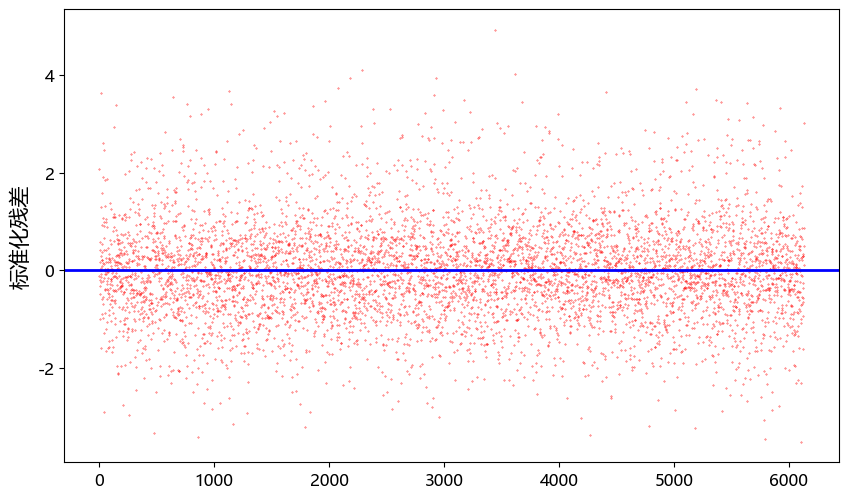

In [37]:
fig = plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(range(len((est2.resid-est2.resid.mean())/est2.resid.std())),(est2.resid-est2.resid.mean())/est2.resid.std(),s=0.1, c='r',alpha=0.9)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('标准化残差',fontsize=15)
plt.axhline(y = 0, color = 'b', linewidth = 2)

In [38]:
#岭回归
alphas = [0.01,0.1,1,10]
lr = RidgeCV(alphas=alphas,store_cv_values=True)
lr.fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print("训练集r2_score评分：",r2_score(y_train,y_train_pred))
print("测试集r2_score评分：",r2_score(y_test,y_test_pred))

训练集r2_score评分： 0.6621199222177714
测试集r2_score评分： 0.658475716088998


最佳正则参数为： 1.0


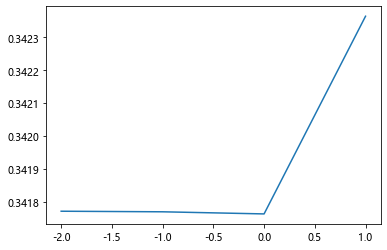

In [39]:
print("最佳正则参数为：",lr.alpha_)
mse_mean = np.mean(lr.cv_values_,axis=0)
plt.plot(np.log10(alphas),mse_mean.reshape(len(alphas),1))

In [40]:
print('系数:',lr.coef_)  # 系数
print('常量:', lr.intercept_)  # 常量
print('求y_train预测值:',lr.predict(x_train))  # 求预测值
print('求y_test预测值:',lr.predict(x_test)) 
print(lr.get_params())  # 获取参数信息

系数: [[-0.17548394 -0.33179444 -0.49866952 -0.61841995 -0.68763584 -0.70508955
  -0.44635723  0.03380837  0.58787576 -0.13832995 -0.48114229 -0.49960524
  -0.45695636 -0.43067263 -0.46206249 -0.31732637 -0.07853742  0.35447111
   0.96805859  0.61741173  0.52851387  0.52394684  0.31556172  0.30219625
   0.29556929  0.54618242  0.14599571 -1.46789913  0.43055344 -0.20251109
   0.09789667 -0.11298724]]
常量: [-0.27211988]
求y_train预测值: [[-0.91463489]
 [ 1.40612627]
 [-0.35988567]
 ...
 [-1.31443513]
 [ 0.93541945]
 [-0.87272278]]
求y_test预测值: [[-0.51784776]
 [-1.05044605]
 [-0.06082162]
 ...
 [-0.36682393]
 [-0.4707457 ]
 [ 0.45130029]]
{'alpha_per_target': False, 'alphas': array([ 0.01,  0.1 ,  1.  , 10.  ]), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'normalize': False, 'scoring': None, 'store_cv_values': True}


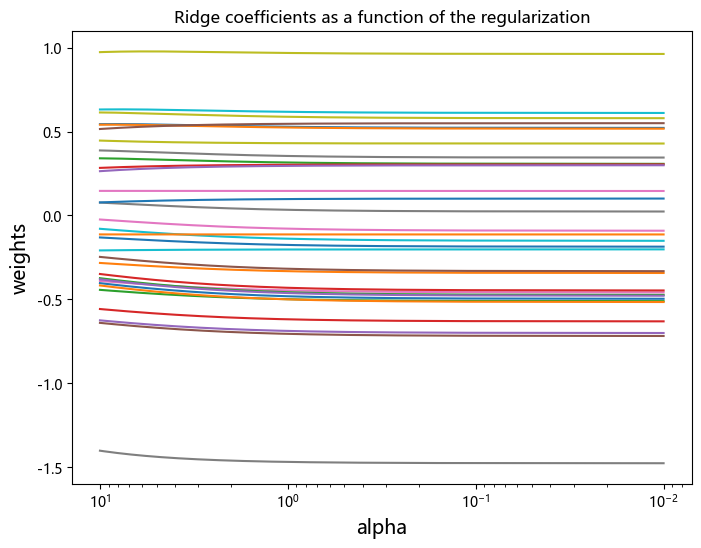

In [41]:
alphas = np.linspace(0.01, 10, num=200)
clf = RidgeCV(fit_intercept=True)
coefs = []
for a in alphas:
    clf = RidgeCV(alphas=a, fit_intercept=True, store_cv_values=True)
    clf.fit(x_train,y_train)
    y_train_pred = clf.predict(x_train)
    coefs.append(clf.coef_)
coefs1 = []
for i in coefs:
    coefs1.append(i[0])
coefs1
fig, ax = plt.subplots(figsize=(8,6),dpi =100)
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, coefs1)
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha',fontsize=14)
plt.ylabel('weights',fontsize=14)
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.rcParams['axes.unicode_minus']=False
plt.show()

In [42]:
#Lasso回归
alphas = [0.01,0.1,1,10,100]
ls =LassoCV(alphas=alphas)
ls.fit(x_train,y_train)

y_train_pred = ls.predict(x_train)
y_test_pred = ls.predict(x_test)

print(r2_score(y_train,y_train_pred))
print(r2_score(y_test,y_test_pred))

0.6088544308196863
0.6085724010442147


C:\Users\Wangt1998\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [43]:
print('系数:',ls.coef_)  # 系数
print('常量:', ls.intercept_)  # 常量
print('求y_train预测值:',ls.predict(x_train))  # 求预测值
print('求y_test预测值:',ls.predict(x_test)) 
print(ls.get_params())  # 获取参数信息

系数: [-0.         -0.         -0.1160428  -0.21773779 -0.29181296 -0.29433282
 -0.04583483  0.          0.54050413  0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.28299694
  0.86355519  0.50066035  0.40139074  0.4056014   0.20901955  0.08420363
 -0.          0.26258235  0.         -1.12993625  0.55855355 -0.23458922
 -0.01764627 -0.09964617]
常量: -0.1391847562535284
求y_train预测值: [-0.67655166  1.03302179 -0.30403917 ... -1.06565998  0.66471467
 -0.81740164]
求y_test预测值: [-0.30456113 -0.98088368  0.08123056 ... -0.13120066 -0.52169558
  0.33707862]
{'alphas': [0.01, 0.1, 1, 10, 100], 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'normalize': False, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}
